In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

import warnings

warnings.filterwarnings("ignore")

# load data

In [2]:
root = Path('data/processed/')

In [3]:
orders_count = pd.read_csv(root / 'orders_count.csv')
orders_count.head(3)

,date,count,product_name,city_id
0,2017-01-01,1,fit,2
1,2017-01-03,144,fit,2
2,2017-01-04,0,fit,2


In [4]:
new_orders_count = pd.read_csv(root / 'new_orders_count.csv')
new_orders_count.head(3)

,date,count,product_name,city_id
0,2017-01-03,22,fit,2
1,2017-01-04,0,fit,2
2,2017-01-06,4,fit,2


In [5]:
fact_deliveries_count = pd.read_csv(root / 'fact_deliveries_count.csv')
fact_deliveries_count.head(3)

,count,planned_delivery_date,city_id,production_type_id,name
0,34,2022-10-27,2,185,elementaree_1
1,168,2022-10-26,1,19,balance_2_2
2,1,2022-10-26,1,20,detox_2_2


In [6]:
f = lambda s: s.split('_')[0]
fact_deliveries_count = fact_deliveries_count.assign(product_name=fact_deliveries_count.name.apply(f))
fact_deliveries_count.head(3)

,count,planned_delivery_date,city_id,production_type_id,name,product_name
0,34,2022-10-27,2,185,elementaree_1,elementaree
1,168,2022-10-26,1,19,balance_2_2,balance
2,1,2022-10-26,1,20,detox_2_2,detox


# make dataset

In [7]:
city_id = 1
product = 'balance'

df1 = orders_count[(orders_count.city_id == city_id) & (orders_count.product_name == product)]
df2 = new_orders_count[(new_orders_count.city_id == city_id) & (new_orders_count.product_name == product)]
df3 = fact_deliveries_count[(fact_deliveries_count.city_id == city_id) & 
                            (fact_deliveries_count.product_name == product)] \
            .rename({'planned_delivery_date': 'date'}, axis=1) \
            .drop_duplicates('date')
cols = ['date', 'count']

df = pd.merge(df1[cols], df2[cols], on='date')
df = df.rename(dict(count_x='orders_count',
                    count_y='new_orders_count'), axis=1)
df = pd.merge(df, df3[cols], on='date').rename(dict(count='deliveries_count'), axis=1)
df.sort_values('date', inplace=True)
df.head(3)

,date,orders_count,new_orders_count,deliveries_count
0,2017-08-13,20,2,290
1,2017-08-16,15,8,343
2,2017-08-18,45,21,130


In [8]:
def fill_nan_dates(subdf: pd.DataFrame) -> pd.DataFrame:
    d = subdf.copy()
    d.index = pd.to_datetime(d.date)
    d = d.drop('date', axis=1)

    d = d.asfreq('1d')
    d.fillna(method='ffill', inplace=True)
    d = d.reset_index()
    return d

df = fill_nan_dates(df)
df = df.iloc[-200:]

In [9]:
df = df.rename(dict(date='timestamp', deliveries_count='target'), axis=1) \
       .assign(segment='main')
df.head()

,timestamp,orders_count,new_orders_count,target,segment
1701,2022-04-10,78.0,4.0,294.0,main
1702,2022-04-11,78.0,5.0,181.0,main
1703,2022-04-12,92.0,6.0,298.0,main
1704,2022-04-13,64.0,5.0,209.0,main
1705,2022-04-14,78.0,9.0,285.0,main


In [10]:
df_raw = df.copy()

In [11]:
df_raw.head()

,timestamp,orders_count,new_orders_count,target,segment
1701,2022-04-10,78.0,4.0,294.0,main
1702,2022-04-11,78.0,5.0,181.0,main
1703,2022-04-12,92.0,6.0,298.0,main
1704,2022-04-13,64.0,5.0,209.0,main
1705,2022-04-14,78.0,9.0,285.0,main


# make etna dataset

In [12]:
from etna import transforms as T

In [13]:
target_transforms = [
    T.MeanTransform(in_column='target', window=7, out_column='mean_3'),
    
    T.FourierTransform(period=7, order=2, out_column='fourier_7_2'),
    T.FourierTransform(period=9, order=2, out_column='fourier_9_2'),
    
    T.DifferencingTransform(in_column='target', period=2, order=1, out_column='diff_2_1'),
    T.DifferencingTransform(in_column='target', period=2, order=2, out_column='diff_2_2'),
    
    T.HolidayTransform(iso_code='RUS', out_column='holiday_ru'),
]

exog_transforms = [
    T.LagTransform(in_column='orders_count', lags=[5, 6, 7], out_column='lag_orders_count'),
    T.LagTransform(in_column='new_orders_count', lags=[2, 7, 9], out_column='lag_new_orders_count')
]

In [14]:
import pandas as pd
from etna.datasets import TSDataset

exog_features = df_raw.drop(['target'], axis=1)
exog_ts = TSDataset.to_dataset(exog_features)

# apply transforms
for tr in exog_transforms:
    exog_ts = tr.fit_transform(exog_ts)
exog_ts = exog_ts.fillna(0)


# Create a TSDataset
cols = [
    'timestamp', 
    'target', 
    'segment'
]
df = TSDataset.to_dataset(df_raw[cols].iloc[:-1])
# apply transforms
for tr in target_transforms:
    df = tr.fit_transform(df)
ts = TSDataset(df, freq="D", df_exog=exog_ts, known_future='all')

# # Choose a horizon
# HORIZON = 14

# # Make train/test split
# train_ts, test_ts = ts.train_test_split(test_size=HORIZON)

In [15]:
ts.df = ts.df.fillna(0)
ts.df_exog = ts.df_exog.fillna(0)
ts.head(3)

segment             main                                            \
feature    fourier_7_2_1 fourier_7_2_2 fourier_7_2_3 fourier_7_2_4   
timestamp                                                            
2022-04-10      0.000000      1.000000      0.000000      1.000000   
2022-04-11      0.781831      0.623490      0.974928     -0.222521   
2022-04-12      0.974928     -0.222521     -0.433884     -0.900969   

segment                                                                        \
feature    fourier_9_2_1 fourier_9_2_2 fourier_9_2_3 fourier_9_2_4 holiday_ru   
timestamp                                                                       
2022-04-10      0.000000      1.000000      0.000000      1.000000          0   
2022-04-11      0.642788      0.766044      0.984808      0.173648          0   
2022-04-12      0.984808      0.173648      0.342020     -0.939693          0   

segment                                                   \
feature    lag_new_orders_count_2 lag_new_orders_count_7   
timestamp                                                  
2022-04-10                    0.0                    0.0   
2022-04-11                    0.0                    0.0   
2022-04-12                    4.0                    0.0   

segment                                                                  \
feature    lag_new_orders_count_9 lag_orders_count_5 lag_orders_count_6   
timestamp                                                                 
2022-04-10                    0.0                0.0                0.0   
2022-04-11                    0.0                0.0                0.0   
2022-04-12                    0.0                0.0                0.0   

segment                                                                         
feature    lag_orders_count_7      mean_3 new_orders_count orders_count target  
timestamp                                                                       
2022-04-10                0.0  294.000000              4.0         78.0    0.0  
2022-04-11                0.0  237.500000              5.0         78.0    0.0  
2022-04-12                0.0  257.666667              6.0         92.0    0.0

In [16]:
ts.regressors

['lag_new_orders_count_2',
 'lag_new_orders_count_7',
 'lag_new_orders_count_9',
 'lag_orders_count_5',
 'lag_orders_count_6',
 'lag_orders_count_7',
 'new_orders_count',
 'orders_count']

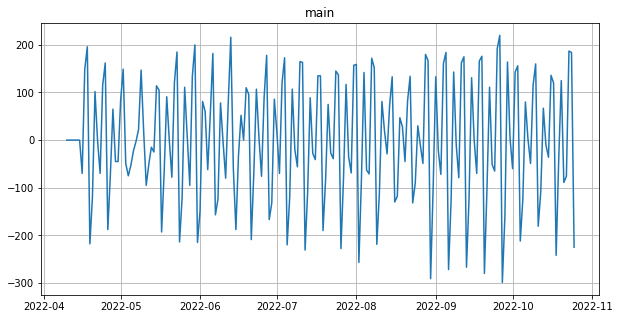

In [17]:
ts.plot()

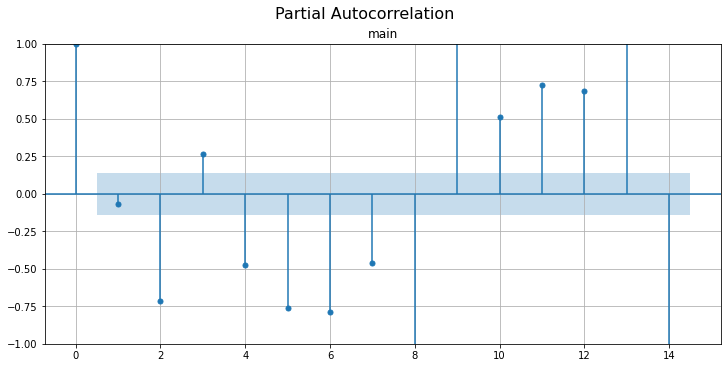

In [18]:
from etna.analysis import sample_pacf_plot

sample_pacf_plot(ts, lags=14)

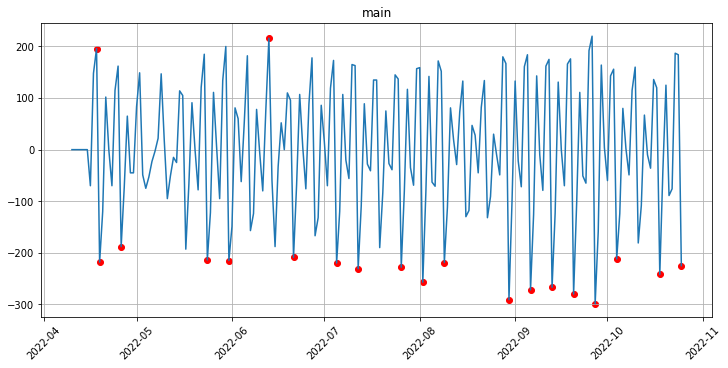

In [19]:
from etna.analysis.outliers import get_anomalies_density
from etna.analysis import plot_anomalies

anomaly_seq_dict = get_anomalies_density(
  ts, window_size=31, distance_coef=1, n_neighbors=10)
plot_anomalies(ts, anomaly_seq_dict)

# one model prediction

In [20]:
from etna.models.nn.mlp import MLPModel
from etna.transforms import PytorchForecastingTransform, DateFlagsTransform

import torch
import numpy as np
import random 

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [21]:
_, cols = zip(*ts.df.columns.tolist())
cols = list(cols)

real_cols = list(cols)
for col in (
    'holiday_ru', 
    'target'
):
    real_cols.remove(col)
cat_cols = ['holiday_ru']

In [32]:
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.data.encoders import NaNLabelEncoder

HORIZON = 7

transform_date = DateFlagsTransform(day_number_in_week=True, day_number_in_month=False, out_column="dateflag")

transform_deepar = PytorchForecastingTransform(
    max_encoder_length=HORIZON,
    max_prediction_length=HORIZON,
    time_varying_unknown_categoricals=["time_idx"] + cat_cols,
    time_varying_unknown_reals=["target"] + real_cols,
    # time_varying_known_categoricals=["dateflag_day_number_in_week"] + cat_cols,
    # categorical_encoders=dict(
    #     holiday_ru=NaNLabelEncoder(add_nan=True)
    # ),
    target_normalizer=GroupNormalizer(groups=["segment"]),
)

In [40]:
ts.df.to_csv('./data/train/ts.csv', index=False)

In [36]:
from etna.models.nn.deepar import DeepARModel
from etna.metrics import SMAPE, MAPE, MAE
from etna.pipeline import Pipeline

mlp_params = dict(
    input_size=17,
    decoder_length=HORIZON,
    hidden_size=[32],
    encoder_length=HORIZON,
    train_batch_size=64,
    test_batch_size=64,
)


# model_deepar = DeepARModel(context_length=HORIZON, max_epochs=5, learning_rate=[0.01], gpus=0, batch_size=64)
model_deepar = MLPModel(**mlp_params)
metrics = [SMAPE(), MAPE(), MAE()]

pipeline_deepar = Pipeline(
    model=model_deepar,
    horizon=HORIZON,
    transforms=[transform_date, transform_deepar],
)

TypeError: __init__() got an unexpected keyword argument 'max_epochs'

In [37]:
metrics_deepar, forecast_deepar, fold_info_deepar = pipeline_deepar.backtest(ts, metrics=metrics, n_folds=1, n_jobs=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | loss | MSELoss    | 0     
1 | mlp  | Sequential | 609   
------------------------------------
609       Trainable params
0         Non-trainable params
609       Total params
0.002     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


ValueError: 7 (3.52%) of fourier_7_2_1 values were found to be NA or infinite (even after encoding). NA values are not allowed `allow_missing_timesteps` refers to missing rows, not to missing values. Possible strategies to fix the issue are (a) dropping the variable fourier_7_2_1, (b) using `NaNLabelEncoder(add_nan=True)` for categorical variables, (c) filling missing values and/or (d) optionally adding a variable indicating filled values

In [ ]:
ts

In [ ]:
ts

In [ ]:
metrics_deepar

In [ ]:
from etna.models import (
    SeasonalMovingAverageModel,
    LinearPerSegmentModel,
    CatBoostPerSegmentModel,
    HoltWintersModel
) 
from etna.ensembles import VotingEnsemble
from etna.pipeline import Pipeline
from etna.transforms import BinsegTrendTransform
from sklearn.ensemble import GradientBoostingRegressor


HORIZON = 1
pipelines = [
    # Pipeline(
    #     model=CatBoostPerSegmentModel(),
    #   # model=SeasonalMovingAverageModel(window=10, seasonality=7),
    #   transforms=[
    #     # BinsegTrendTransform(
    #     #   in_column="target",
    #     #   min_size=12,
    #     #   jump=1,
    #     #   model="ar",
    #     #   n_bkps=10
    #     # ),
    #   ],
    #   horizon=HORIZON
    # ),
    # Pipeline(
    #     model=SeasonalMovingAverageModel(window=20, seasonality=7),
    #     horizon=HORIZON
    # ),
    # Pipeline(
    #     model=HoltWintersModel(use_boxcox=True, trend='add', damped_trend=False, seasonal='add', seasonal_periods=7),
    #     horizon=HORIZON
    # ),
    # Pipeline(
    #     model=HoltWintersModel(use_boxcox=True, trend='add', damped_trend=False, seasonal='add', seasonal_periods=7),
    #     horizon=HORIZON
    # )
]

# voting_ensemble = VotingEnsemble(pipelines, regressor=GradientBoostingRegressor)

In [ ]:
from etna.metrics import MAE, SMAPE, MSE

metrics_list = [MAE(), SMAPE(), MSE()]
metrics_df, backtest_df, _ = pipelines[0].backtest(
    ts=ts,
    metrics=metrics_list,
    n_folds=20,
    aggregate_metrics=True
)

In [ ]:
metrics_df

In [ ]:
from etna.analysis.plotters import plot_backtest

plot_backtest(backtest_df, ts, history_len=20)

# Other models

In [ ]:
Pipeline(
        model=HoltWintersModel(use_boxcox=True, trend='add', damped_trend=False, seasonal='add', seasonal_periods=7),
        horizon=HORIZON
    )